# Adult Income Classification using Spark MLlib

In this project, we are going to use Spark MLlib on the popular <strong>Adult Income Dataset </strong>[<a href="http://archive.ics.uci.edu/ml/datasets/Adult" target="_BLANK">Source</a>].
The dataset provides different parameters of an individual which might influence his/her income. We want to explore and see if different personal attributes of a person influence his/her income and whether we can use these attributes to predict their income levels. 

We are going to follow the ML approach given below for this project. The ML algorithm we would use here is __Logistic Regression__. 

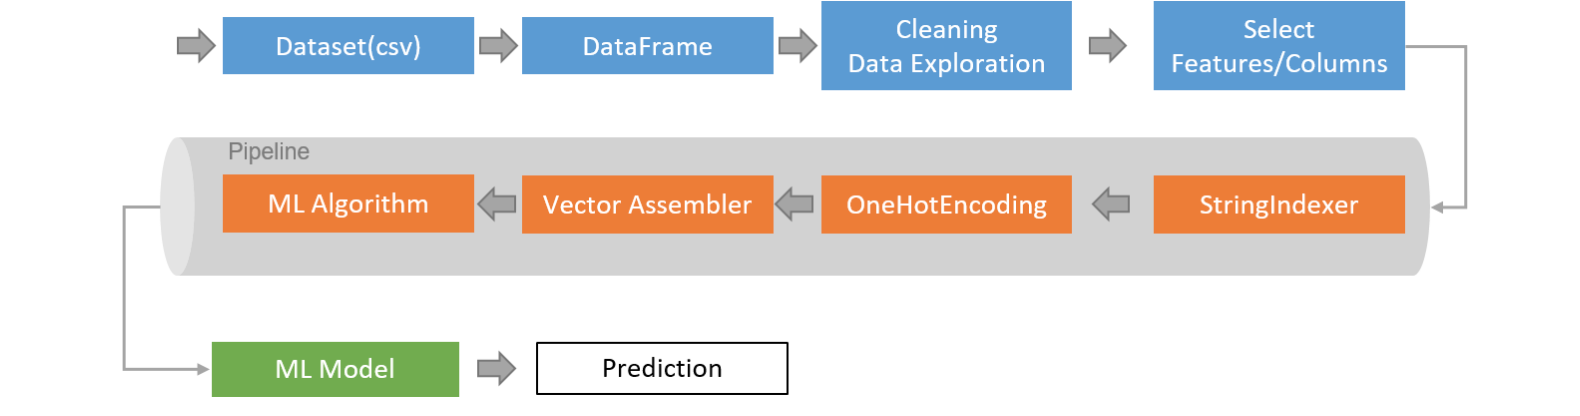

## Initialize Spark Session

In [1]:
# Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Create Spark Configuration Object
master = "local[2]"
app_name = "Spark MLlib Adult Income classification"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## Data Loading and Exploration

In [2]:
#Loading the CSV File
df_adult = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('adult.csv')

In [3]:
#Print the Schema
df_adult.printSchema()

root
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: string (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: string (nullable = true)
 |-- capital-loss: string (nullable = true)
 |-- hours-per-week: string (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [19]:
#Checking the shape of the dataframe
print((df_adult.count(), len(df_adult.columns)))

(48842, 15)


In [4]:
# Check data summary
df_adult.describe().toPandas().head()

,summary,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
1,mean,38.64358543876172,None,189664.13459727284,None,10.078088530363212,None,None,None,None,None,1079.0676262233324,87.50231358257237,40.422382375824085,None,None
2,stddev,13.710509934443502,None,105604.02542315764,None,2.570972755592251,None,None,None,None,None,7452.019057655418,403.0045521243594,12.391444024252284,None,None
3,min,17,?,100009,10th,1,Divorced,?,Husband,Amer-Indian-Eskimo,Female,0,0,1,?,<=50K
4,max,90,Without-pay,99987,Some-college,9,Widowed,Transport-moving,Wife,White,Male,99999,974,99,Yugoslavia,>50K


For simplicity, we are only going to use the following columns: <code> 'workclass','education','marital status','occupation','relationship','race','gender','income' </code>.

In [5]:
cols=['workclass','education','marital-status','occupation','relationship','race','gender','income']
df = df_adult[cols]
df.show(5)

+---------+------------+------------------+-----------------+------------+-----+------+------+
|workclass|   education|    marital-status|       occupation|relationship| race|gender|income|
+---------+------------+------------------+-----------------+------------+-----+------+------+
|  Private|        11th|     Never-married|Machine-op-inspct|   Own-child|Black|  Male| <=50K|
|  Private|     HS-grad|Married-civ-spouse|  Farming-fishing|     Husband|White|  Male| <=50K|
|Local-gov|  Assoc-acdm|Married-civ-spouse|  Protective-serv|     Husband|White|  Male|  >50K|
|  Private|Some-college|Married-civ-spouse|Machine-op-inspct|     Husband|Black|  Male|  >50K|
|        ?|Some-college|     Never-married|                ?|   Own-child|White|Female| <=50K|
+---------+------------+------------------+-----------------+------------+-----+------+------+
only showing top 5 rows



In [8]:
# Exploring target variable
df.select('income').distinct().show()

+------+
|income|
+------+
| <=50K|
|  >50K|
+------+



In [7]:
# checking for null values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+---------+--------------+----------+------------+----+------+------+
|workclass|education|marital-status|occupation|relationship|race|gender|income|
+---------+---------+--------------+----------+------------+----+------+------+
|        0|        0|             0|         0|           0|   0|     0|     0|
+---------+---------+--------------+----------+------------+----+------+------+



## Implement a Pipeline for all the transformers and estimators 

In [9]:
# preparing train test data
train, test = df.randomSplit([0.9, 0.1], seed=12345)

### Stage 1: String Indexing

<code>StringIndexer</code> encodes string columns as indices. It assigns a unique value to each category. We also need to define the input column/columns name and the output column/columns name in which we want the results. 

In [10]:
from pyspark.ml.feature import StringIndexer

inputCols=[x for x in df.columns]#input columns for StringIndexer
outputCols=['workclass_index','education_index','marital-status_index',\
            'occupation_index','relationship_index','race_index','gender_index','label']#output columns for StringIndexer

stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols)

### Stage 2: One hot encoding

<code>One hot encoding</code> is representation of categorical variables as binary vectors and is slightly different from what we have been doing in scikit learn. It works in 2 steps:

* The categorical variables are mapped as integer values

* Each integer value is represented as binary vector

In [11]:
from pyspark.ml.feature import OneHotEncoder

inputCols_OHE = [x for x in outputCols if x != 'label']#input columns for OHE
outputCols_OHE = [f'{x}_vec' for x in inputCols if x != 'income']#output columns for OHE

stage_2 = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)

### Stage 3: Vector Assembler

Finally, once we have transformed the data, we want to combine all the features into a single feature column to train the machine learning model. <code>VectorAssembler</code> combines the given list of columns to a <em>single vector</em> column.

In [12]:
from pyspark.ml.feature import VectorAssembler

inputCols= stage_2.getOutputCols()#input columns 

stage_3 = VectorAssembler(inputCols=inputCols, outputCol='features')

### Stage 4: ML algorithm

Here we are using <code>Logistic Regression</code> for the classification.

In [13]:
from pyspark.ml.classification import LogisticRegression

#define LogistRegression method with appropriate parameters
stage_4 = LogisticRegression(featuresCol='features',labelCol='label', maxIter=10, regParam=0.001)

### Pipeline API
We finally plugin the above 4 stages of transformers/estimaters into a <code>Pipeline API</code> and create the ML model for <code>Logistic Regression</code>. Using this model, we further generate predictions for the test data and examine the accuracy. 

In [14]:
from pyspark.ml import Pipeline

# plugging the stages into the pipline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4])

# training the model
model = pipeline.fit(train)

# generating the predictions
prediction = model.transform(test)

In [15]:
prediction.select('features', 'label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(53,[3,15,23,36,4...|  0.0|
|(53,[3,15,23,36,4...|  0.0|
|(53,[3,15,23,36,4...|  1.0|
|(53,[3,15,24,36,4...|  0.0|
|(53,[3,15,24,36,4...|  0.0|
+--------------------+-----+
only showing top 5 rows



### Evaluating model performance

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator.evaluate(prediction))

Logistic Regression Accuracy: 0.8328316275336143


## Summary

Through this project, we were able to build a decent classifier model but the main highlight was the pipeline methodology adopted which significantly reduced the training time (as opposed to serial execution in scikit learn). To further increase the accuracy of the model, we could also use a Gradient Boosting classifier or a random forest classifer. 